In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from scipy.io import loadmat
from sklearn.ensemble import IsolationForest

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#function for loading charge cycle of .mat file
def charge_data(battery):
    mat = loadmat('' + f'../Data & Outputs/Nasa/{battery}' + '.mat') 
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []

  
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'charge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
      
              
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_charge = data[0][0]['Current_charge'][0][j]
                voltage_charge = data[0][0]['Voltage_charge'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, 
                        voltage_measured, current_measured,
                        temperature_measured, current_charge,
                        voltage_charge, time])
      
            counter = counter + 1
    print(dataset[0])
    return pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_charge', 'voltage_charge', 'time'])

#function for loading discharge cycle of .mat file
def discharge_data(battery):
    mat = loadmat('' + f'../Data & Outputs/Nasa/{battery}' + '.mat') 
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []

  
    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
              
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, 
                        capacity,voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      
            counter = counter + 1
    print(dataset[0])
    return pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                 'capacity','voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time'])



### NASA Feature Engineering

In [3]:
cells = ['B0005','B0006', 'B0007','B0018'] #selecting the cells that we are going to use

In [4]:
cell_data = {}

# Store charge and discharge data in dictionary
for cell in cells:
    cell_data[cell] = {
        "charge": charge_data(cell),
        "discharge": discharge_data(cell)
    }

# Calculate SoH for each cell's discharge data
for cell in cells:
    C = 2
    for i in range(len(cell_data[cell]["discharge"])):
        cell_data[cell]["discharge"]["SoH"] = cell_data[cell]["discharge"]["capacity"] / C

# Process charge data for each cell
for cell in cells:
    df = []
    for i in range(1, np.max(cell_data[cell]["charge"]["cycle"]) + 1):
        a = cell_data[cell]["charge"].loc[cell_data[cell]["charge"]["cycle"] == i]
        b = a[a['voltage_measured']>3.9].iloc[0]['time']
        c = a[a['voltage_measured']>4.0].iloc[0]['time']
        d = a[a['voltage_measured']>4.1].iloc[0]['time']
        e = a[a['voltage_measured']>4.2].iloc[0]['time']
        f = a['time'].iloc[-1] - a[a['voltage_measured']>4.2].iloc[0]['time']
        df.append([i, b, c, d, e, f])

    # Store processed charge data and SoH data in dictionary
    cell_data[cell]["charge_processed"] = pd.DataFrame(data=df, columns=['cycle', 'time 3.9v', 'time 4.0v', 'time 4.1v','time 4.2v', 'time end'])
    cell_data[cell]["SoH"] = pd.DataFrame(data=cell_data[cell]["discharge"].SoH.unique(), columns=['SoH'])
    cell_data[cell]["SoH"].index = cell_data[cell]["SoH"].index + 1
    cell_data[cell]["final_charge"] = cell_data[cell]["charge_processed"].assign(SoH=cell_data[cell]["SoH"])

    # Save final charge data to CSV file
    #cell_data[cell]["final_charge"].to_csv(f'../Data & Outputs/Nasa/{cell}.csv')


Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.873017221300996, -0.001200660698297908, 24.65535783391511, 0.0, 0.003, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.864623580255829, 8.199926367719631e-05, 24.682213821908466, -0.001, -0.007, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 13, 8, 17), 3.866123109975637, -0.0038300299369588755, 24.434243987750175, -0.0006, 0.002, 0.0]
Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0

### NASA EDA

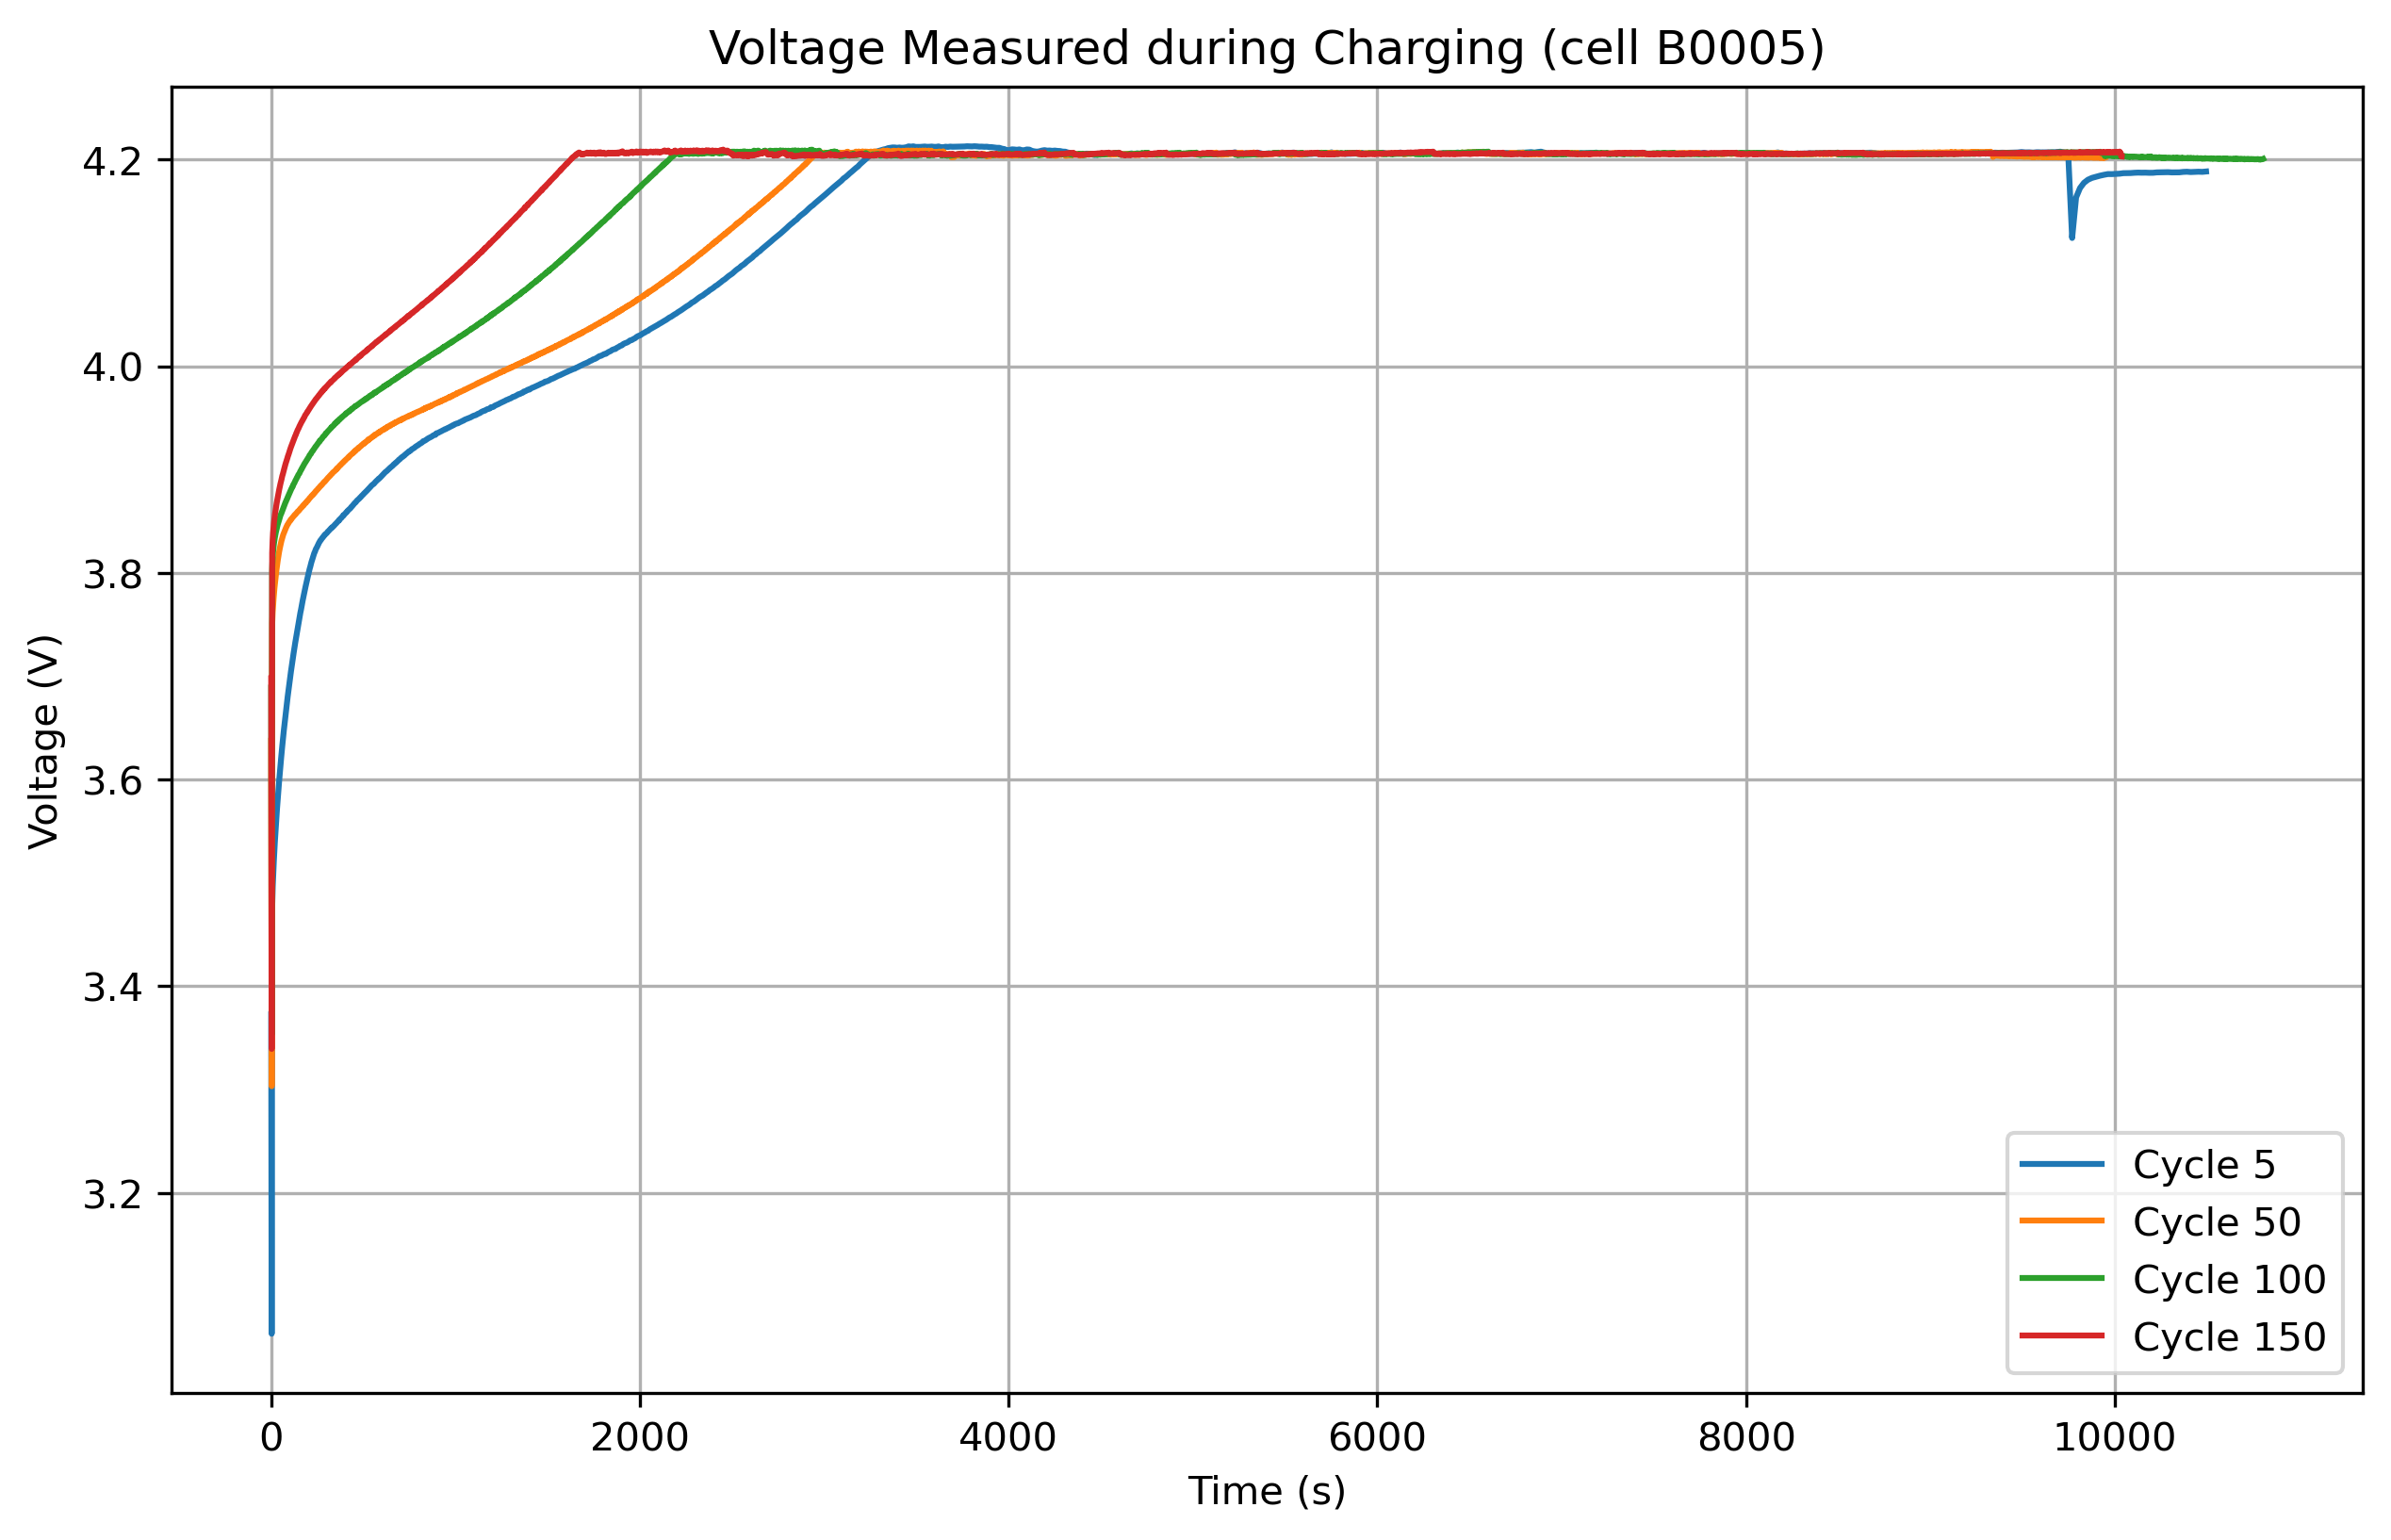

In [5]:
B0005_charge = cell_data['B0005']['charge']

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

cycles = [5, 50, 100, 150]
for cycle in cycles:
    sns.lineplot(x=B0005_charge[B0005_charge['cycle'] == cycle]['time'], 
                 y=B0005_charge[B0005_charge['cycle'] == cycle]['voltage_measured'], 
                 label=f'Cycle {cycle}')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Measured during Charging (cell B0005)')
plt.legend()
plt.grid()
plt.show()

In [6]:
train_B0005 = cell_data['B0005']['final_charge'].assign(cell='B0005')
train_B0006 = cell_data['B0006']['final_charge'].assign(cell='B0006')
train_B0007 = cell_data['B0007']['final_charge'].assign(cell='B0007')
train_B0018 = cell_data['B0018']['final_charge'].assign(cell='B0018')

train = pd.concat([train_B0005, train_B0006, train_B0007, train_B0018])

### Removing Outliers

In [7]:
train = train.dropna()

In [8]:
# Identify outliers using Isolation Forest
iso = IsolationForest(random_state=42, contamination = 0.05)
outlier_labels = iso.fit_predict(train.drop(columns=['cell']))

# Replace outliers with NaN values
train = train[outlier_labels == 1] 

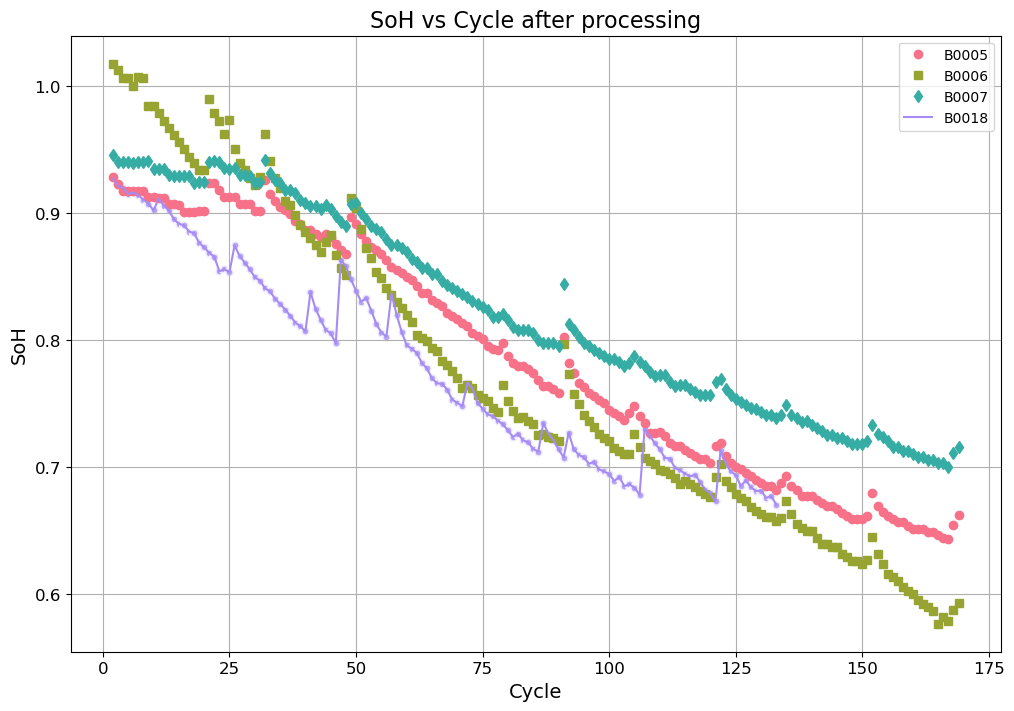

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

markers = ['o', 's', 'd', 'b']
colors = sns.color_palette('husl', n_colors=len(markers))

# Plot each cell's data
for i, cell in enumerate(['B0005', 'B0006', 'B0007', 'B0018']):
    df = cell_data[cell]['final_charge']
    ax.plot(df['cycle'], df['SoH'], markers[i], color=colors[i], label=cell)
    sns.scatterplot(x='cycle', y='SoH', data=df, color=colors[i], linewidth=2, alpha=0.8)


ax.legend()
ax.set_xlabel('Cycle', fontsize=14)
ax.set_ylabel('SoH', fontsize=14)
ax.set_title('SoH vs Cycle after processing', fontsize=16)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()


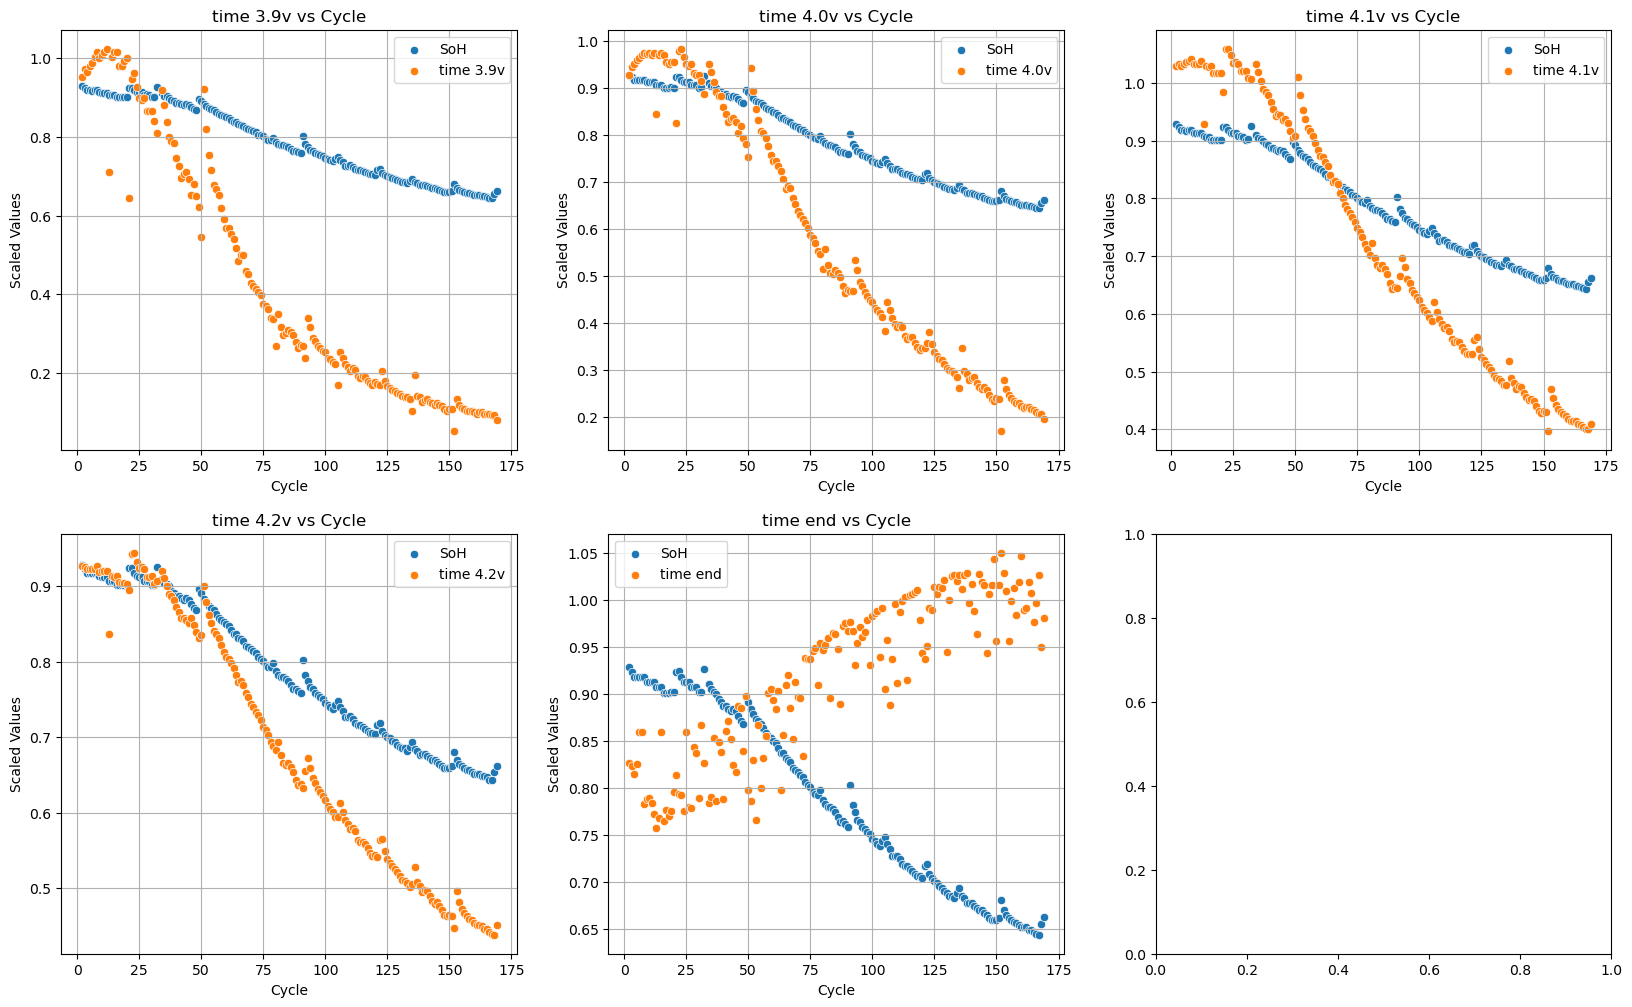

In [10]:
def plot_nasa(ax, title, time_col, scale):
    ax.set_title(title)
    sns.scatterplot(x=train[train['cell']=='B0005']['cycle'], y=train[train['cell']=='B0005']['SoH'], label='SoH', ax=ax)
    sns.scatterplot(x=train[train['cell']=='B0005']['cycle'], y=train[train['cell']=='B0005'][time_col]/scale, label=time_col, ax=ax)
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Scaled Values')
    ax.legend()
    ax.grid()

fig, axs = plt.subplots(2, 3, figsize=(20, 12))
plot_nasa(axs[0, 0], 'time 3.9v vs Cycle', 'time 3.9v', 650)
plot_nasa(axs[0, 1], 'time 4.0v vs Cycle', 'time 4.0v', 1750)
plot_nasa(axs[0, 2], 'time 4.1v vs Cycle', 'time 4.1v', 2500)
plot_nasa(axs[1, 0], 'time 4.2v vs Cycle', 'time 4.2v', 3500)
plot_nasa(axs[1, 1], 'time end vs Cycle', 'time end', 8800)

In [11]:
cell_names = ['B0005', 'B0006', 'B0007', 'B0018']

for cell in cell_names:
    cell_pro = train[train['cell'] == cell]
    cell_pro.to_csv(f'../Data & Outputs/Nasa/{cell}_pro.csv', index=False)

### Calce EDA

In [12]:
cells = ['CS2_35','CS2_36','CS2_37','CS2_38'] #selecting the cells that we are going to use

In [13]:
dataframes = {}
processed_dataframes = {}

for cell in cells:
    df = pd.read_csv(f'../Data & Outputs/Calce/{cell}.csv')
    df = df[['cycle', 'capacity', 'CCCT', 'CVCT']].copy()
    df['SoH'] = df['capacity']/1.1
    df.drop(['capacity'], axis=1, inplace=True) 
    df['cell'] = cell
    
    dataframes[cell] = df

    df_pro = df.copy()
    df_pro = df_pro.dropna()

    iso = IsolationForest(random_state=42, contamination = 0.05)
    outlier_labels = iso.fit_predict(df_pro.drop(columns=['cell', 'cycle']))

    df_pro = df_pro[outlier_labels == 1] 
    df_pro.to_csv(f'../Data & Outputs/Calce/{cell}_pro.csv', index=False)

    processed_dataframes[cell] = df_pro

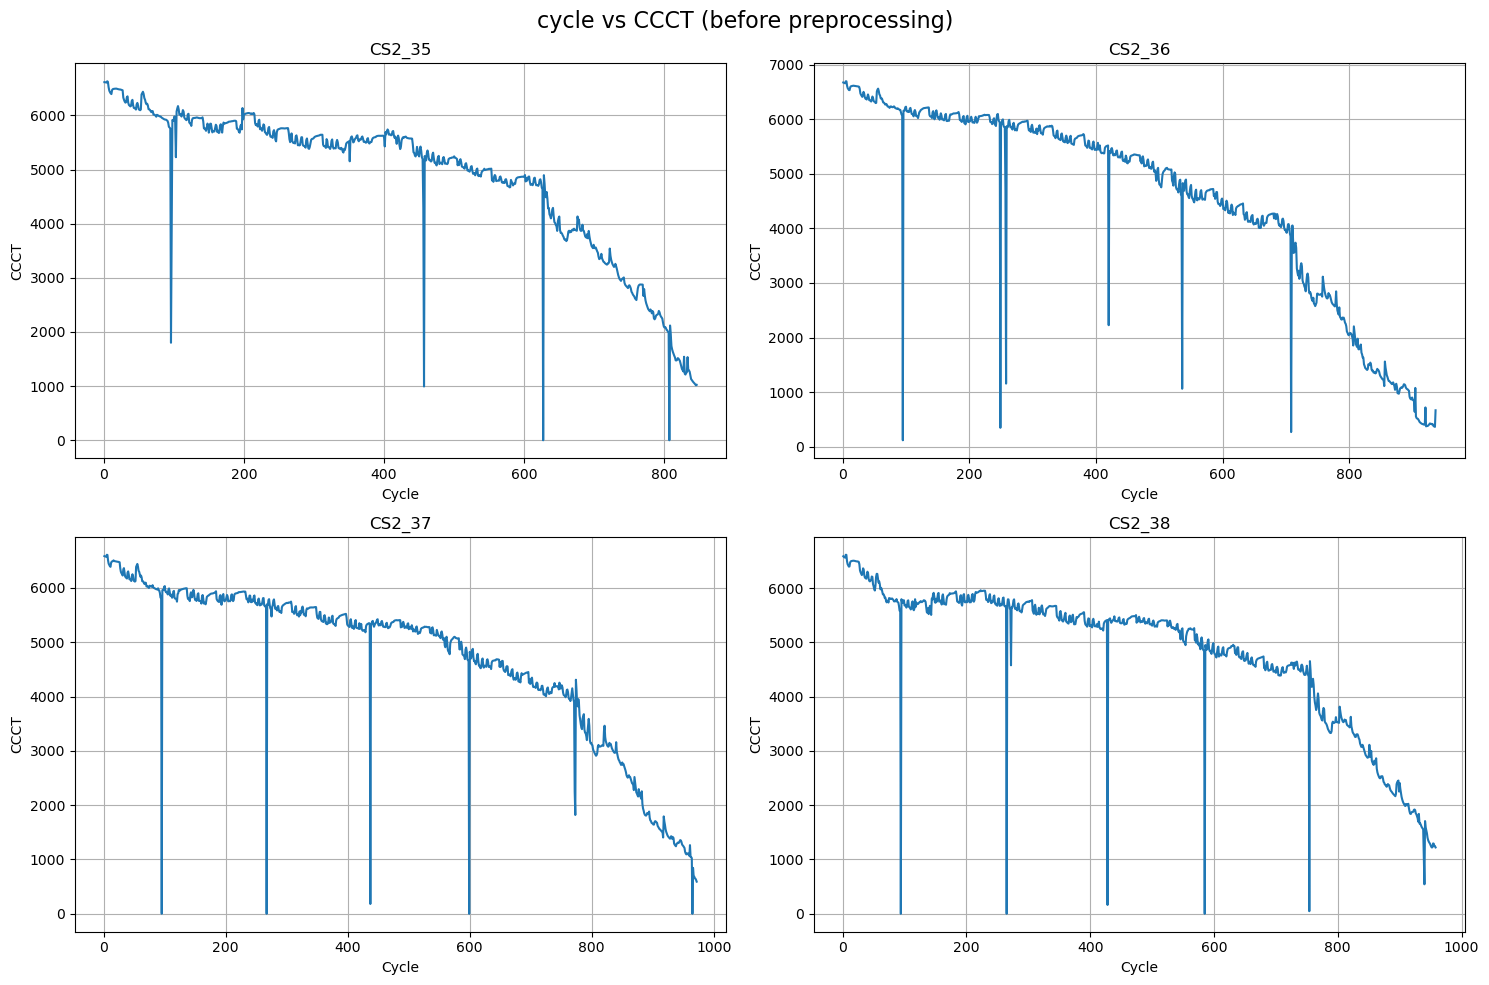

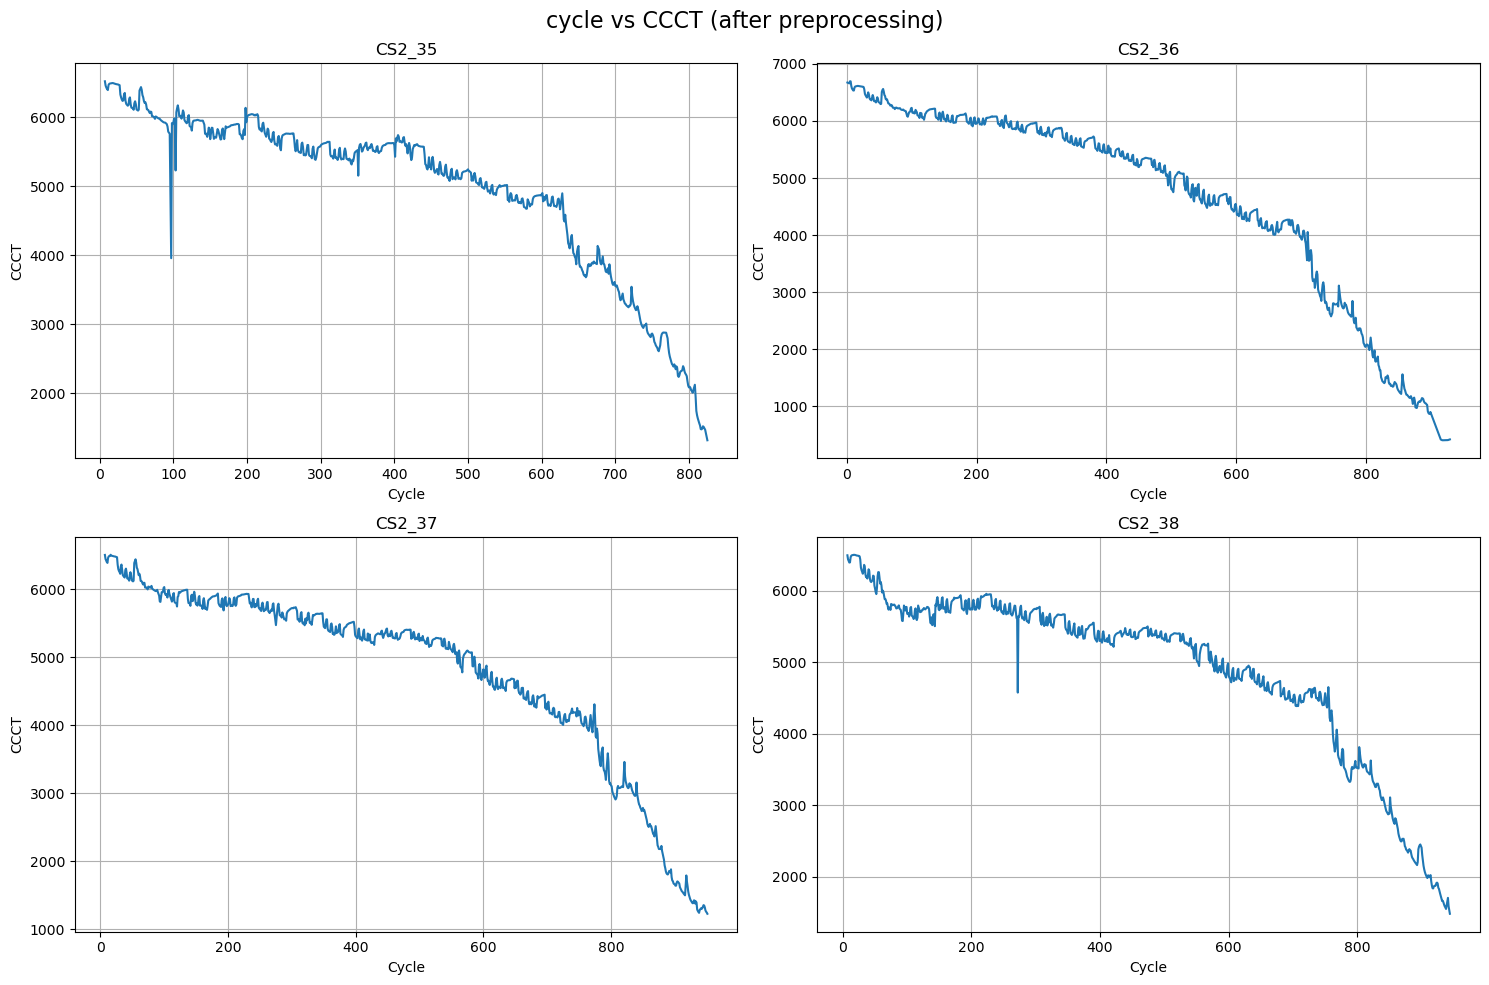

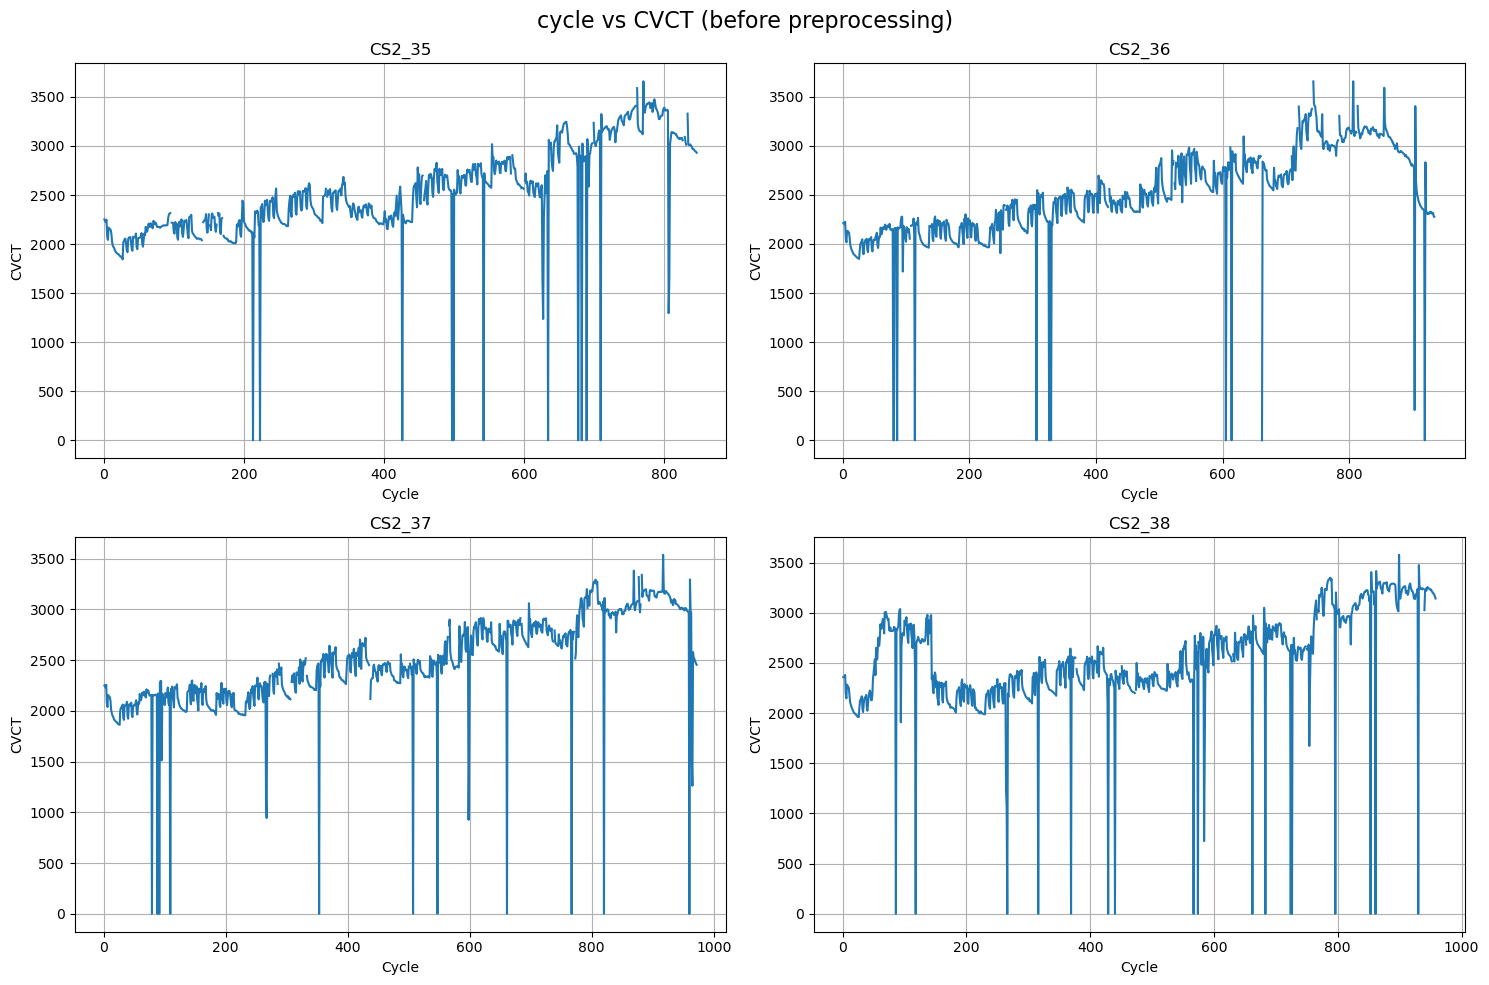

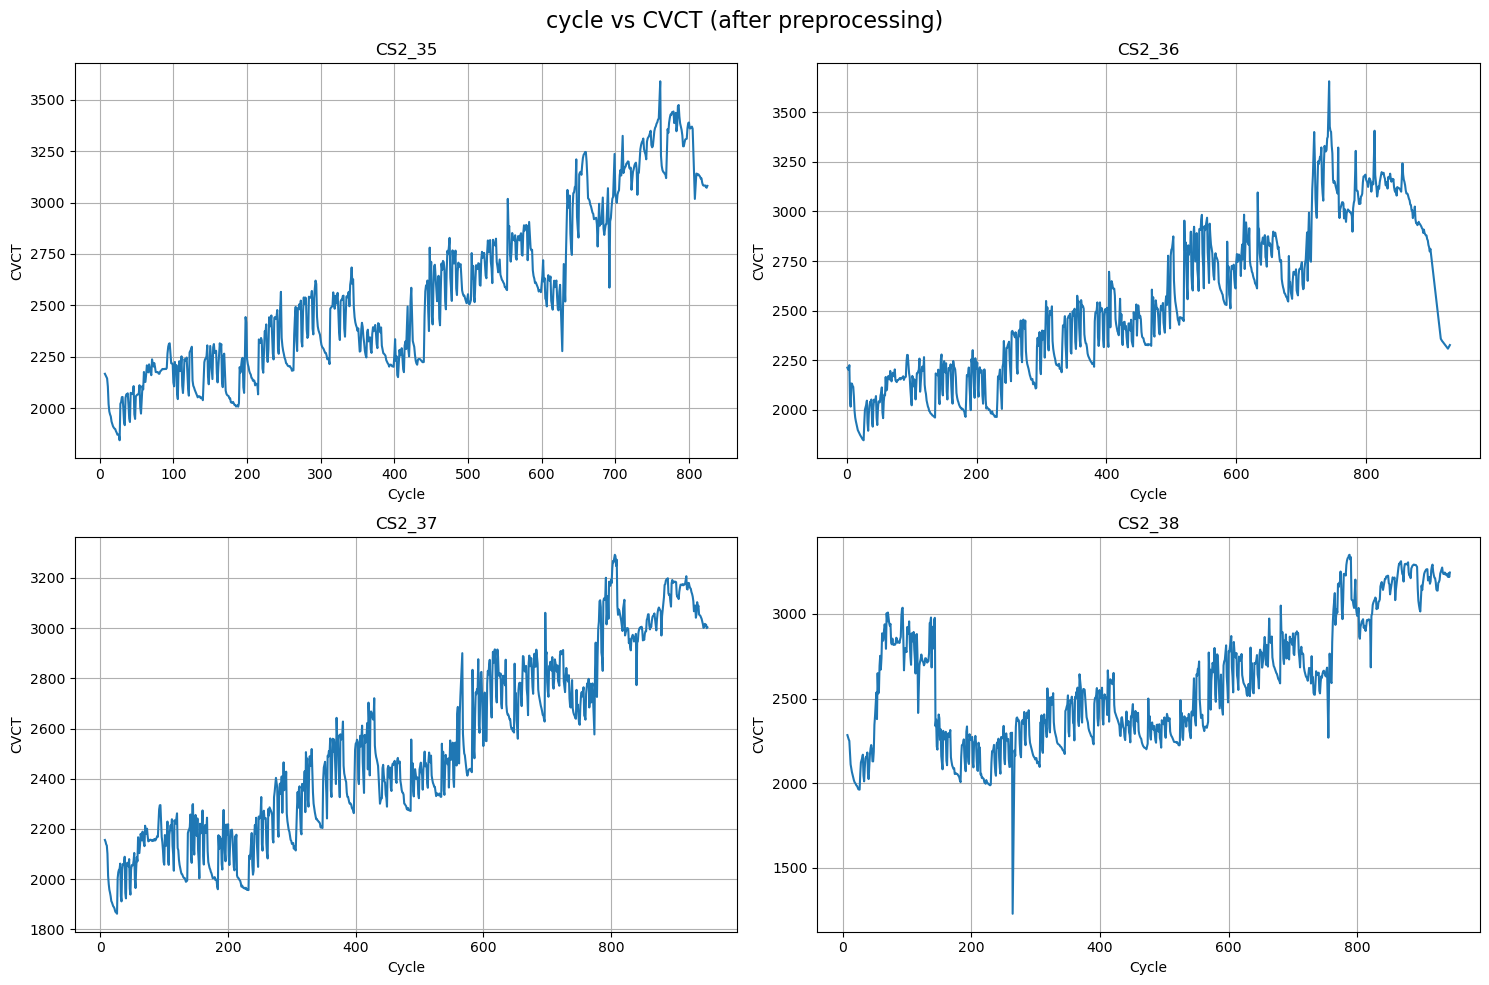

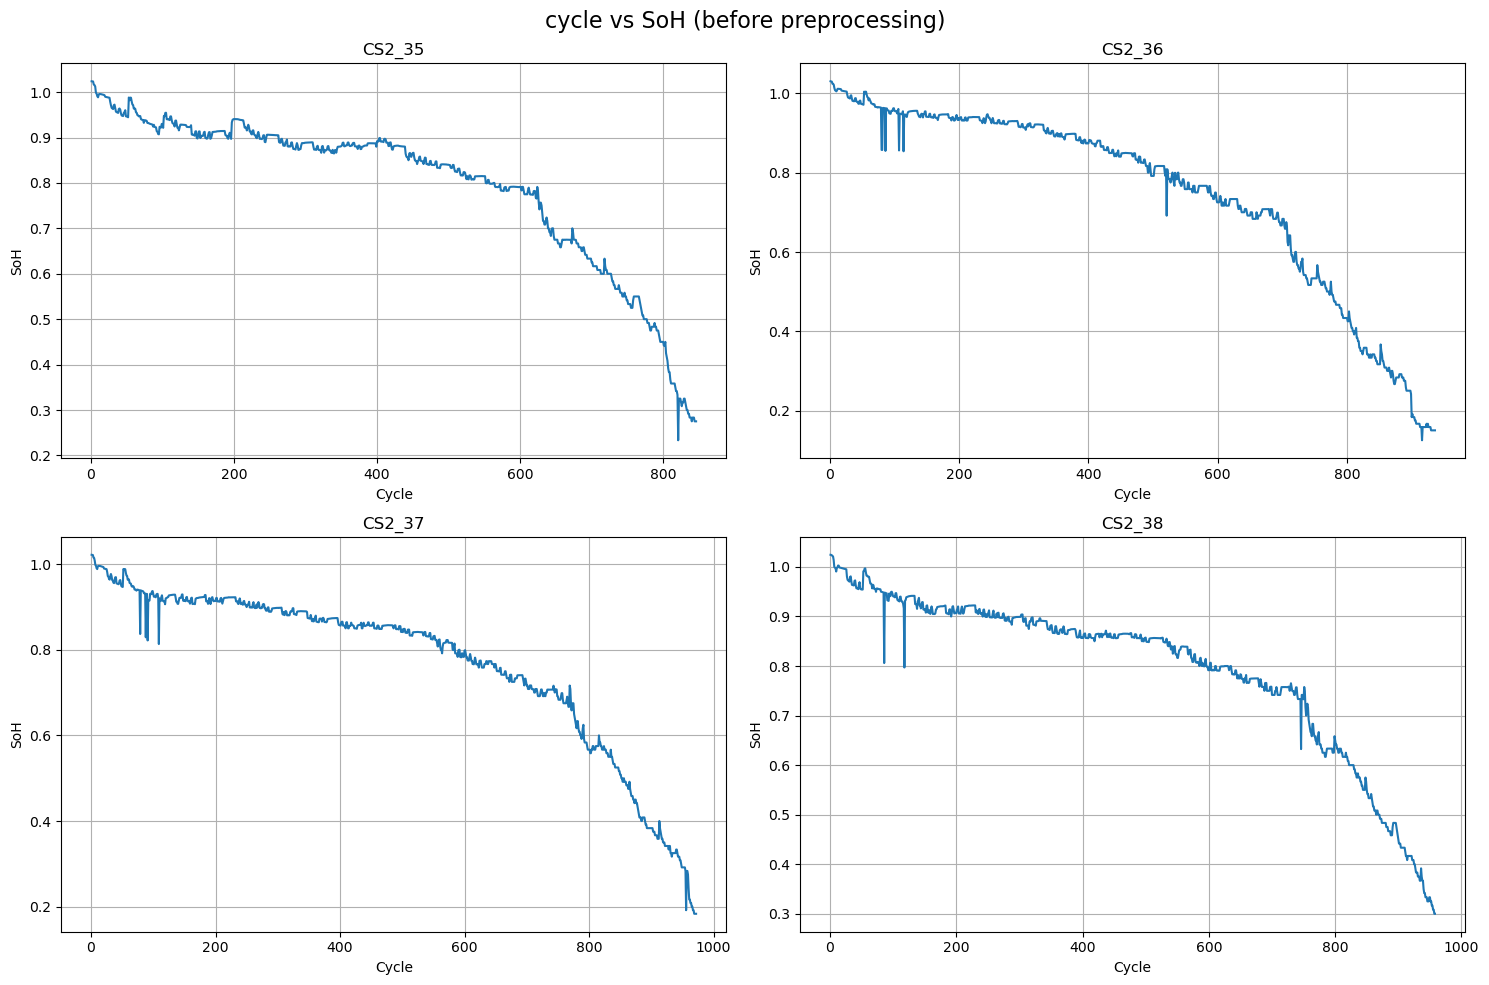

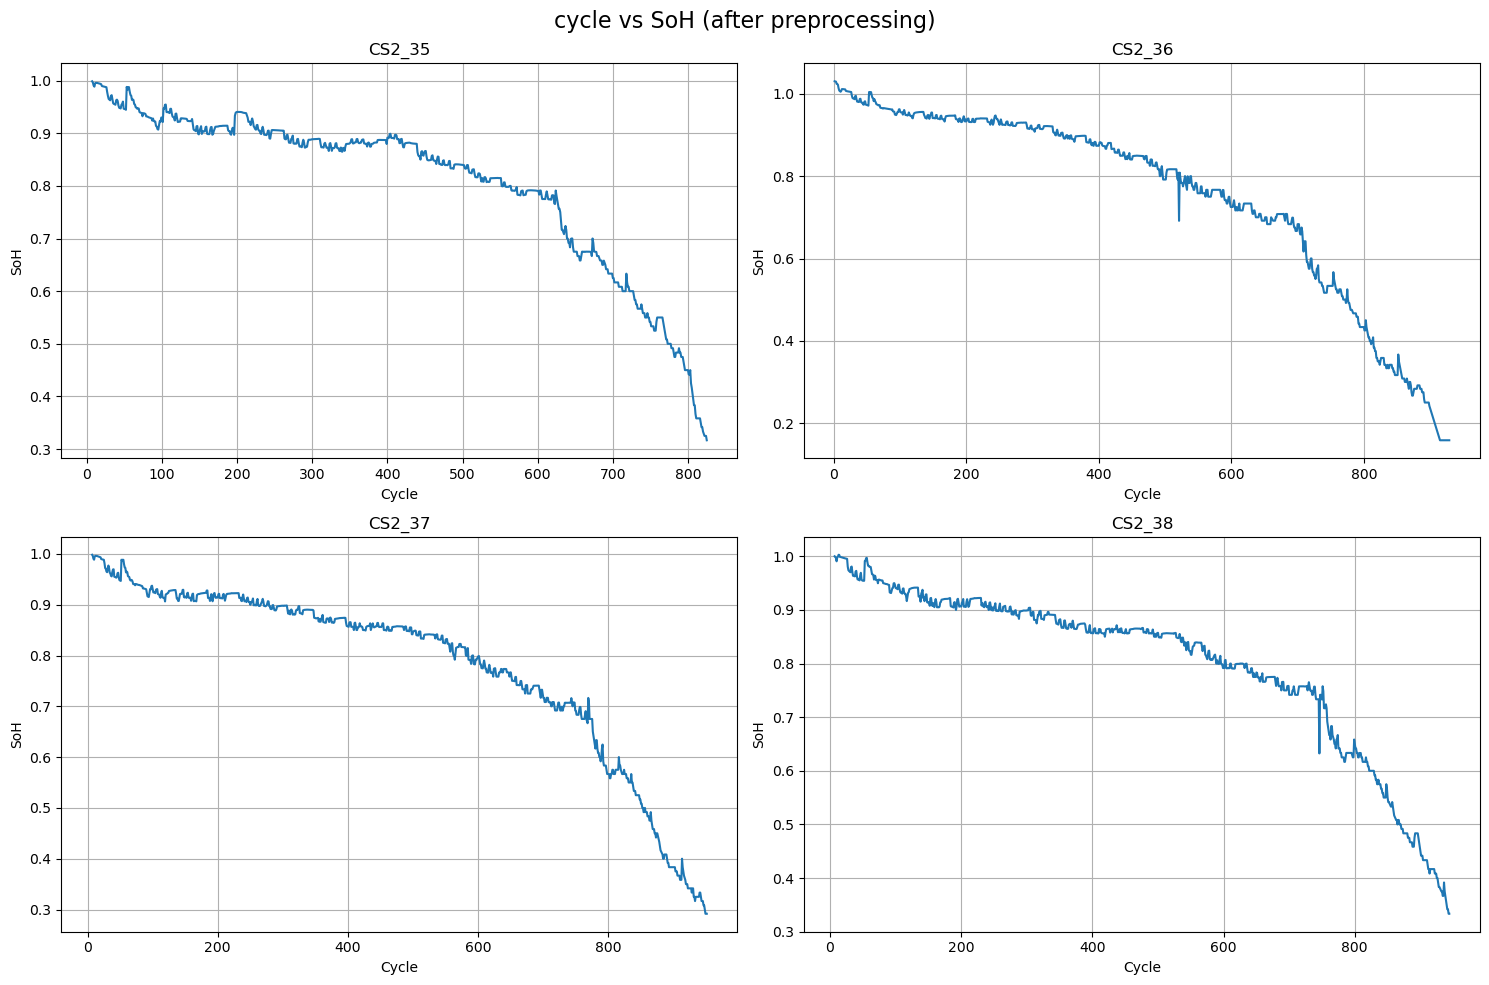

In [14]:
def plot_calce(df, y_label, when):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()
    for i, cell in enumerate(cells):
        ax[i].plot(df[cell]['cycle'], df[cell][y_label])
        ax[i].set_title(cell)
        ax[i].set_xlabel('Cycle')
        ax[i].set_ylabel(y_label)
        ax[i].grid()
    plt.suptitle(f'cycle vs {y_label} ({when} preprocessing)', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_calce(dataframes, 'CCCT', 'before')
plot_calce(processed_dataframes, 'CCCT', 'after')
plot_calce(dataframes, 'CVCT', 'before')
plot_calce(processed_dataframes, 'CVCT', 'after')
plot_calce(dataframes, 'SoH', 'before')
plot_calce(processed_dataframes, 'SoH', 'after')